## Lab 4 - part 2: Data Weights and Autocorellation

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



## Exercise 4a: Spatial Autocorrelation and ESDA 

USE the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

In [54]:
import geopandas as gpd
import osmnx as ox
from pysal.lib import weights
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster
import pandas as pd
import numpy as np

**Load up the IMD dataset for Liverpool.**

In [55]:
'''
Source: lab-04-part-01
Load up whole IMD dataset and save to imd.
'''

imd_shp = 'data/IMD/lab04_imd.shp' #file path
imd = gpd.read_file(imd_shp).set_index("lsoa11cd", drop=False) #read shapefile, set unique identifier as lsoa11cd do not drop this column

In [56]:
'''
Filter for only liverpool.
'''
liverpool_imd = imd[imd['LADnm'] == "Liverpool"] #filter out IMD dataset for england for only liverpool (place we are concerned)
liverpool_imd.head() #display dataset.

,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,LADnm,...,IndDec,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
lsoa11cd,,,,,,,,,,,,,,,,,,,,,
E01006512,E01006512,Liverpool 031A,Liverpool 031A,283906.863775,3063.168774,14664,5,Liverpool 031A,E08000012,Liverpool,...,1,0.536,8031,3,2975,255,2639,81,2649.50,"POLYGON ((335888.000 390042.000, 336203.000 39..."
E01006513,E01006513,Liverpool 060A,Liverpool 060A,555037.185423,5835.725743,11173,4,Liverpool 060A,E08000012,Liverpool,...,1,0.974,4329,2,4418,103,4222,93,4257.75,"POLYGON ((335374.808 390547.998, 335405.406 39..."
E01006514,E01006514,Liverpool 037A,Liverpool 037A,262030.747956,3243.503128,3299,2,Liverpool 037A,E08000012,Liverpool,...,1,0.550,7888,3,1760,87,1439,234,1538.25,"POLYGON ((335650.536 389928.121, 335677.916 38..."
E01006515,E01006515,Liverpool 037B,Liverpool 037B,366499.754871,4273.694263,1875,1,Liverpool 037B,E08000012,Liverpool,...,3,0.615,7285,3,1438,176,1013,249,1014.75,"POLYGON ((335178.000 389642.000, 335222.397 38..."
E01006518,E01006518,Liverpool 044A,Liverpool 044A,235181.260598,2743.746370,330,1,Liverpool 044A,E08000012,Liverpool,...,2,0.564,7747,3,1732,287,971,474,993.00,"POLYGON ((335528.316 389067.946, 335612.896 38..."


**Create a choropleth of the `imd_score` variable.**

What is chloropleth: https://geographicdata.science/book/notebooks/05_choropleth.html


Text(0.5, 1.0, 'Chloropleth of IMDScore in Liverpool')

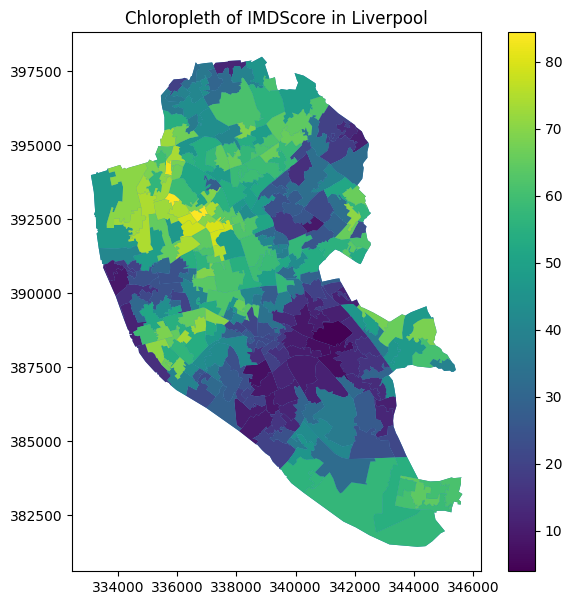

In [57]:
'''
Source: lab-04-part-02
Plot base axis for liverpool aread.
Plot chloropleth so that you can see the difference through the city in IMD score.
'''
ax = liverpool_imd.plot(figsize=(7, 7)) #from lab-04-part-02
liverpool_imd.plot(column='IMDScore', ax=ax, legend=True) #focused on IMD, legend = True shows the colour bar on the side. source: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html
plt.title("Chloropleth of IMDScore in Liverpool") #plot title

**Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.**


In [58]:
'''
Deprivation (imd score) is often geographically clustered and related to shared borders or vertices, therefore will use contiguity.
Source: lab-04-part-01
Make contiguity weights matrix from liverpool only imd dataset.
'''
w_queen = weights.Queen.from_dataframe(liverpool_imd, ids="lsoa11cd") #make contiguity from dataframe liverpool_imd
w_queen

In [59]:
w_queen['E01033767'] #test an area to ensure it works (5 neighbours displayed)

{'E01033748': 1.0,
 'E01032505': 1.0,
 'E01006630': 1.0,
 'E01006633': 1.0,
 'E01006632': 1.0}

**Create the standardized version of the IMD scores.**


In [60]:
'''
Source: lab-04-part-02
'''
liverpool_imd['std_imd'] = (liverpool_imd['IMDScore'] - liverpool_imd['IMDScore'].mean()) / liverpool_imd['IMDScore'].std() #standardized imd scores

/mnt/nvme1n1p1/made/data1/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


**Calculate the spatial lag of the standardized scores.**


In [61]:
'''
Source: lab-04-part-02
'''
w_queen.transform = 'R' #standardise weights matrix
w_queen_score = weights.lag_spatial(w_queen, liverpool_imd['std_imd']) #find spatial lag with standarized weights and standardized imd scores

In [62]:
liverpool_imd['std_w_queen_score'] = w_queen_score #set to new column

/mnt/nvme1n1p1/made/data1/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


**Create the Moran Plot.**

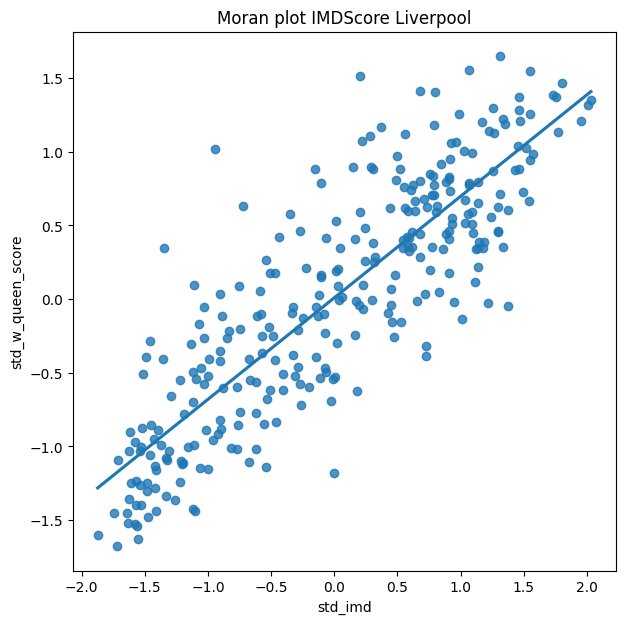

In [63]:
'''
Moran plot = attribute on x axis (standardized IMD score) and spatial lag of attribute on y axis
Source: lab-04-part-02
'''
f, ax = plt.subplots(1, figsize=(7, 7)) #set up figure
sns.regplot(x='std_imd', y='std_w_queen_score', data=liverpool_imd, ci=None) #plot data, set x and y
plt.title("Moran plot IMDScore Liverpool") #make title
plt.show()

**Calculate the value of Moran's I as well as its significance level.**


In [64]:
'''
Use esda.Moran for moran plot 
No need to standardize IMD score before hand.
Source: lab-04-part-02
'''
mi = esda.Moran(liverpool_imd['IMDScore'], w_queen) #prepare moran plot using built in function

In [65]:
mi.I #get moran I score

0.6896035100024694

In [66]:
mi.p_sim #get significance level

0.001

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.69)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

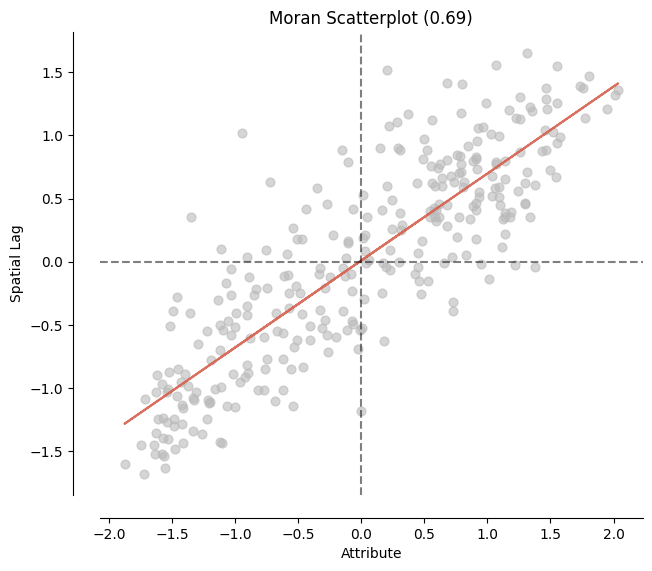

In [67]:
moran_scatterplot(mi) #plot Moran to check previous plot (identical to manual plot made above)

**Perform a LISA analysis and generate a map of the results. What are the main patterns?**

In [68]:
'''
Use esda.Moran_local for LISA analysis
Source: lab-04-part-02
'''
lisa = esda.Moran_Local(liverpool_imd['IMDScore'], w_queen) #prepares LISA analysis 

In [69]:
#Source: lab-04-part-02

liverpool_imd['significant'] = lisa.p_sim < 0.05 # Break observations into significant or not
liverpool_imd['quadrant'] = lisa.q # Store the quadrant they belong to

/mnt/nvme1n1p1/made/data1/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/mnt/nvme1n1p1/made/data1/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

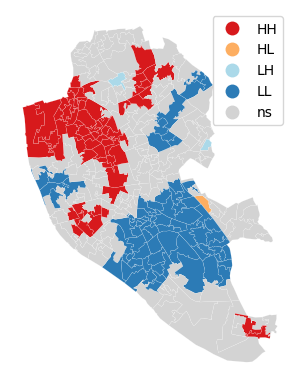

In [70]:
lisa_cluster(lisa, liverpool_imd) # Plot LISA analysis to show spatital relevance of IMD score.

**What are main patterns?**

In the northwest, there is a noticeable cluster of deprived areas, where both each region and its neighbors have high IMD scores, highlighting the spatial significance of this metric. Conversely, in South-Central Liverpool, the area appears wealthier and less deprived, with surrounding neighborhoods following a similar trend. Additionally, there are smaller clusters showing a mix of spatially more deprived and less deprived areas.

There are a few exceptions: two neighborhoods with low IMD scores are surrounded by highly deprived areas with high IMD scores, and one neighborhood with a high IMD score is surrounded by wealthier areas with low IMD scores

For this part I would like you to experiment with Data from Amsterdam. However this will require you to find the dataset yourself!

## Question 1: Building a Contiguity-Based Weight Matrix

Use PySAL to create a contiguity-based weight matrix (W) for a given spatial dataset of polygons. Write a function create_contiguity_weights that:

    Reads in a shapefile of polygons.
    Constructs a Queen contiguity-based spatial weights matrix.
    Returns the weight matrix.

## Question 2: Calculating Moran’s I

Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.

## Question 3: Standardizing Spatial Weight Matrices

Create a function standardize_weights that:

    Takes a spatial weight matrix W.
    Standardizes it so that the weights of each row sum to one.
    Returns the standardized weight matrix.

## Question 4: Creating Distance-Based Weights

Write a function create_distance_weights that:

    Takes a set of point coordinates and a threshold distance.
    Constructs a distance-based spatial weight matrix where all points within the threshold distance are assigned a weight.
    Returns the weight matrix.

## Question 5: Visualizing a Moran Plot

Using PySAL, write a function plot_moran that:

    Takes a spatial weights matrix W and an attribute array y.
    Creates and displays a Moran plot for the attribute.
    Saves the Moran plot as an image file.

**Question 0: Prepare dataset**

In [71]:
'''
No dataset found with shapefile + useful metric for amsterdam. 
Found a shapefile and separate csv for amsterdam airbnb scraped data.
Therefore must combine to have usefull attributes we can analysis spatially.
Data source: https://www.kaggle.com/code/erikbruin/airbnb-the-amsterdam-story-with-interactive-maps
'''

ams_shp = 'data/mygeodata/neighbourhoods-polygon.shp' #shapefile path
ams = gpd.read_file(ams_shp) #read shapefile
ams = ams.rename(columns={'neighbourh': 'neighbourhood'}) #make sure columns are labelled well
ams = ams.drop(columns=['neighbou_1']) #drop useless column
ams.head() #display shapefile dataframe



,neighbourhood,geometry
0,Bijlmer-Oost,"POLYGON Z ((4.99167 52.32444 43.06929, 4.99176..."
1,Noord-Oost,"POLYGON Z ((5.07916 52.38865 42.95663, 5.06710..."
2,Noord-West,"POLYGON Z ((4.93072 52.41161 42.91539, 4.93051..."
3,Oud-Noord,"POLYGON Z ((4.95242 52.38983 42.95411, 4.95242..."
4,IJburg - Zeeburgereiland,"POLYGON Z ((5.03906 52.35458 43.01664, 5.02022..."


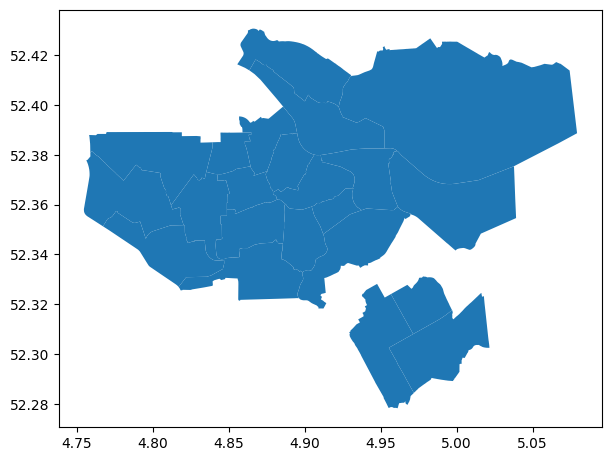

In [72]:
ax = ams.plot(figsize=(7, 7)) #plot base to ensure it works

In [73]:
'''
Load and display airbnb data that is going to be combined with shape data
'''
airbnb_listings=pd.read_csv('data/mygeodata/listings.csv') #load csv file with pandas to later insert into shapefile
airbnb_listings.head() #display csv of airbnb scraped data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,1,44
1,3209,"Quiet apt near center, great view",3806,Maartje,NaN,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,1,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,NaN,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,2,198
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,NaN,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,2,141
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,1,199


In [74]:
'''
Only take relevant data.
Number of listings per neighbourhood.
And average price of listings per neighbourhood.
'''
grouped_df = airbnb_listings.groupby('neighbourhood').agg(count=('price', 'size'), average_price=('price', 'mean')).reset_index() #per neighbourhood make count of all listings, make mean of all the prices
grouped_df.head() #display refined dataset


,neighbourhood,count,average_price
0,Bijlmer-Centrum,111,91.216216
1,Bijlmer-Oost,96,101.604167
2,Bos en Lommer,1145,116.996507
3,Buitenveldert - Zuidas,262,153.087786
4,Centrum-Oost,1730,189.376301


In [75]:
'''
Combine datasets
'''
ams = ams.merge(grouped_df, on='neighbourhood', how='left') #use geopandas to merge attribute data with shapedata source: https://geopandas.org/en/stable/docs/user_guide/mergingdata.html
ams.head() #display merged datasets

,neighbourhood,geometry,count,average_price
0,Bijlmer-Oost,"POLYGON Z ((4.99167 52.32444 43.06929, 4.99176...",96,101.604167
1,Noord-Oost,"POLYGON Z ((5.07916 52.38865 42.95663, 5.06710...",257,118.638132
2,Noord-West,"POLYGON Z ((4.93072 52.41161 42.91539, 4.93051...",320,120.171875
3,Oud-Noord,"POLYGON Z ((4.95242 52.38983 42.95411, 4.95242...",571,157.684764
4,IJburg - Zeeburgereiland,"POLYGON Z ((5.03906 52.35458 43.01664, 5.02022...",452,165.157080


Text(0.5, 1.0, 'Chloropleth of average airbnb price in Amsterdam')

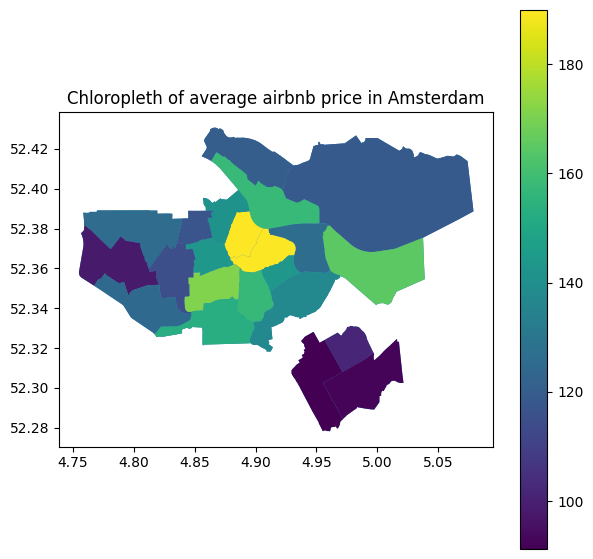

In [76]:
'''
Plot chlorpleth average airbnb price in amsterdam to check data.
'''
ax = ams.plot(figsize=(7, 7)) #set up base axis to plot chlorpleth
ams.plot(column='average_price', ax=ax, legend=True) #plot to display differing average airbnb price source: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html
plt.title("Chloropleth of average airbnb price in Amsterdam") #make title

In [77]:
'''
Use to save shapefile+attributes dataframe
'''
#ams.to_file('airbnb-amsterdam.shp')

**Question 1: Building a Contiguity-Based Weight Matrix**

In [78]:
ams.head() #display ready dataframe

,neighbourhood,geometry,count,average_price
0,Bijlmer-Oost,"POLYGON Z ((4.99167 52.32444 43.06929, 4.99176...",96,101.604167
1,Noord-Oost,"POLYGON Z ((5.07916 52.38865 42.95663, 5.06710...",257,118.638132
2,Noord-West,"POLYGON Z ((4.93072 52.41161 42.91539, 4.93051...",320,120.171875
3,Oud-Noord,"POLYGON Z ((4.95242 52.38983 42.95411, 4.95242...",571,157.684764
4,IJburg - Zeeburgereiland,"POLYGON Z ((5.03906 52.35458 43.01664, 5.02022...",452,165.157080


In [80]:
def create_contiguity_weights(dataframe): #define function, input geopandas dataframe
    '''
    Create and return contiguity matrix for dataframe (no set index)
    Source: lab-04-part-01
    '''
    w_queen = weights.Queen.from_dataframe(dataframe) #create contiguity weights
    return(w_queen) #return

#test function
w_queen = create_contiguity_weights(ams) #create weights for ams airbnb dataframe
w_queen[1] #display neighbours of Noord-oost

/tmp/ipykernel_16495/4180433704.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = weights.Queen.from_dataframe(dataframe)
/mnt/nvme1n1p1/made/data1/env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


{2: 1.0, 3: 1.0, 4: 1.0, 6: 1.0}

**Question 2: Calculating Moran’s I**

In [31]:
def calculate_morans_i(W,y): #define function input weights matrix and attribute list
    '''
    Create and return contiguity matrix for dataframe (no set index)
    Source: lab-04-part-02
    '''
    mi = esda.Moran(y, W) #use package esda.Moran to prepare Moran analysis
    return mi.I, mi.p_sim #return Moran I score and significance level
    
#test function
i,p_sim = calculate_morans_i(w_queen, ams['average_price']) #find Moran I and significance with contiguity matrix and average price of airbnb
print(i,p_sim) #print found data

0.546869482158763 0.001


**Question 3: Standardizing Spatial Weight Matrices**

In [32]:
def standardize_weights(W): #define function, input weights matrix
    '''
    Standardize weights for all rows of neighbourhours (example: 1,1 -> 0.5,0.5)
    Source: lab-04-part-01
    '''
    W.transform = 'R' #standardize 
    return W #return standardized matrix


#test function
w_queen = standardize_weights(w_queen) #standardized contiguity matrix for ams airbnb dataset
w_queen[1] #print neighbourhours (previously seen as 1 1 1 1)

{2: 0.25, 3: 0.25, 4: 0.25, 6: 0.25}

**Question 4: Creating Distance-Based Weights**

In [42]:
'''
Check crs as inportant when calculating distance of neighbourhoods 
Currently in long-lat degrees
Source: lab-04-part-01
'''
ams.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
'''
Must change crs to metres in order to create distance weights with coordinate points.
Source: lab-04-part-01
'''
ams=ox.project_gdf(ams) #convert to metres
ams.crs #display to ensure successful

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [52]:
'''
Two functions:
Create distance weights, which takes an array of coordinates and a threshod in metres.
Get centre points, assumes dataframe axis in metres and gets the centre points of each area in dataframe
Source: lab-04-part-01
'''

def create_distance_weights(pts, threshold):#input is threshold (m) and coordinates
    w_distkm = weights.DistanceBand.from_array(pts, threshold) #use from_array as input is not matrix but coordinates
    return w_distkm #return matrix of for certain threshold neighbours

# test
def get_centre_points(dataframe): #define function input dataframe (axis in metres)
    #Source: lab-04-part-01
    cents = dataframe.centroid #gets centre points for dataframe
    pts = np.array([(pt.x, pt.y) for pt in cents]) #splits them into a list of tuples for x,y of each centre point
    return pts #returns list of coordinates

#test function
pts=get_centre_points(ams) #get points for amsterdam dataframe
w_dist5km=create_distance_weights(pts, 5000) #get neighbourhood matrix for each in threshold of 5km
w_dist5km[1] #display 5km neighbour from centre of Noord-oost

{4: 1.0}

**Question 5: Visualizing a Moran Plot**

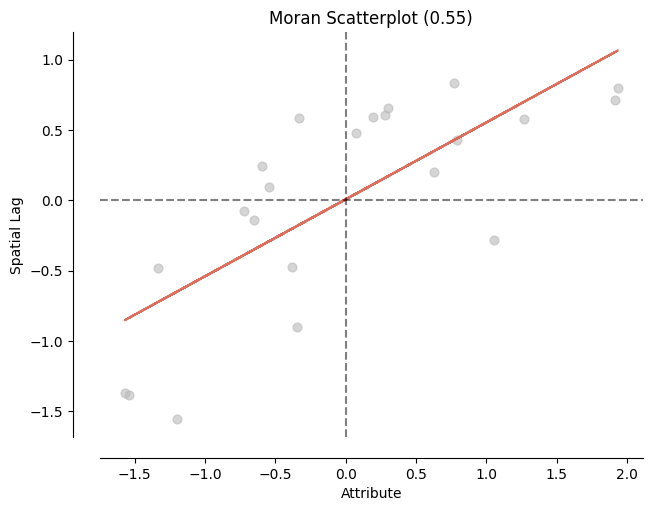

In [53]:
'''
Use esda.Moran to plot attribute against spatial lag
Save to hardcoded file moranplot.png
Source: lab-04-part-02
'''

def plot_moran(W,y):#define function input weights neighbour matrix and list of attribute
    mi = esda.Moran(y, W) #prepare moran
    moran_scatterplot(mi) #plot moran plot
    plt.savefig("moranplot.png") #save moran plot

plot_moran(w_queen, ams['average_price']) #test with amsterdam contiguity matrix on attribute average airbnb price in amsterdam